<a href="https://colab.research.google.com/github/ZloyEgor/Lab3/blob/master/%D0%9F%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B0%D1%8F_%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%B0_3_%E2%80%93_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классификация цветов с помощью свёрточных нейронных сетей.


В работе необходимо познакомится с различными архитектурами сверхточных нейронных сетей и их обучением на GPU (англ. graphics processing, графический процессор) на языке программирования Python 3 и фреймворка Torch (PyTorch).  Для этого предлагается использовать ресурсы Google Colab - Colaboratory, для выполнения вычислений на GPU. После с ознакомления, выполнить практическое задане в конце данной тетради (notebook).

Рассмотрим [Датасет](https://www.kaggle.com/alxmamaev/flowers-recognition ) содержащий 4242 изображения цветов размеченных по 5 видам (тюльпан, ромашка, подсолнух, роза, одуванчик). Данный набор данных можно скачать по [ссылке](https://www.kaggle.com/alxmamaev/flowers-recognition ) с сайте kaggle.

Загрузите папку с картинками на гугл диск, чтобы не загружать ее каждый раз заново при перезапуске колаба. Структура файлов (можно посмотреть в меню слева) может быть такой: "/content/drive/My Drive/data/flowers".
Обязательно подключите аппаратный ускоритель (GPU) к среде выполнения, чтобы вычисления были. В меню сверху: Среда выполнения -> Сменить среду выполнения

Первым делом разберите более детально код выполнив код ниже.

# Подготовка

Загружаем библиотеки. Фиксируем random.seed для воспроизводимости

In [ ]:
import numpy as np # linear algebra
import os
import torch
import torchvision
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

random.seed(0)
torch.manual_seed(0)

Выбираем на чем будем делать вычисления - CPU или GPU (cuda)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'data/flowers'

assert FOLDERNAME is not None, "[!] Enter the foldername."

%cd drive/My\ Drive
#%cp -r $FOLDERNAME ../../
#%cd ../../
%cd data/flowers/
#!bash get_datasets.sh
#%cd ../../

In [ ]:
prepare_imgs = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((224, 224)), #приводим картинки к одному размеру
        torchvision.transforms.ToTensor(), # упаковывем их в тензор
        torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225] # нормализуем картинки по каналам
        ),
    ]
)
# задаем датасет. Лейблы - имена папок: 
dataset = ImageFolder('/content/drive/My Drive/data/flowers', transform=prepare_imgs)

In [ ]:
dataset.imgs[2]

In [ ]:
class ValueMeter(object):
  """
  Вспомогательный класс, чтобы отслеживать loss и метрику
  """
  def __init__(self):
      self.sum = 0
      self.total = 0

  def add(self, value, n):
      self.sum += value*n
      self.total += n

  def value(self):
      return self.sum/self.total

def log(mode, epoch, loss_meter, accuracy_meter, best_perf=None):
  """
  Вспомогательная функция, чтобы 
  """
  print(
      f"[{mode}] Epoch: {epoch:0.2f}. "
      f"Loss: {loss_meter.value():.2f}. "
      f"Accuracy: {100*accuracy_meter.value():.2f}% ", end="\n")

  if best_perf:
      print(f"[best: {best_perf:0.2f}]%", end="")


# Сверточная нейросеть с нуля

## Вручную прописываем слои

In [ ]:
model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*28*28, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 5))
model.to(device) # отправляем модель на девайс (GPU)

Задаем гиперпараметры для обучения:

# Задаем параметры и функцию для обучения. Разбиваем датасет на train/validation

In [ ]:
batch_size = 32 # размер батча
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
lr = 0.001 # learning rate

Разбиваем датасет на train и validation

Задаем dataloader'ы - объекты для итеративной загрузки данных и лейблов для обучения и валидации

In [ ]:
train_set, val_set = torch.utils.data.random_split(dataset, [len(dataset)-1000, 1000])
print('Размер обучающего и валидационного датасета: ', len(train_set), len(val_set))
loaders = {'training': DataLoader(train_set, batch_size, pin_memory=True,num_workers=2, shuffle=True),
           'validation':DataLoader(val_set, batch_size, pin_memory=True,num_workers=2, shuffle=False)}

Функция для подсчета Accuracy

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

Функция для обучения и валидации модели

In [ ]:
def trainval(model, loaders, optimizer, epochs=10):
    """
    model: модель, которую собираемся обучать
    loaders: dict с dataloader'ами для обучения и валидации
    optimizer: оптимизатор
    epochs: число обучающих эпох (сколько раз пройдемся по всему датасету)
    """
    loss_meter = {'training': ValueMeter(), 'validation': ValueMeter()}
    accuracy_meter = {'training': ValueMeter(), 'validation': ValueMeter()}

    loss_track = {'training': [], 'validation': []}
    accuracy_track = {'training': [], 'validation': []}

    for epoch in range(epochs): # итерации по эпохам
        for mode in ['training', 'validation']: # обучение - валидация
            # считаем градиаент только при обучении:
            with torch.set_grad_enabled(mode == 'training'):
                # в зависимоти от фазы переводим модель в нужный ружим:
                model.train() if mode == 'training' else model.eval()
                for imgs, labels in tqdm(loaders[mode]):
                    imgs = imgs.to(device) # отправляем тензор на GPU
                    labels = labels.to(device) 
                    bs = labels.shape[0]  # размер батча (отличается для последнего батча в лоадере)

                    preds = model(imgs) # forward pass - прогоняем тензор с картинками через модель
                    loss = F.cross_entropy(preds, labels) # считаем функцию потерь
                    acc = accuracy(preds, labels) # считаем метрику

                    # храним loss и accuracy для батча
                    loss_meter[mode].add(loss.item(), bs)
                    accuracy_meter[mode].add(acc, bs)

                    # если мы в фазе обучения
                    if mode == 'training':
                        optimizer.zero_grad() # обнуляем прошлый градиент
                        loss.backward() # делаем backward pass (считаем градиент)
                        optimizer.step() # обновляем веса
            # в конце фазы выводим значения loss и accuracy
            log(mode, epoch, loss_meter[mode], accuracy_meter[mode])

            # сохраняем результаты по всем эпохам
            loss_track[mode].append(loss_meter[mode].value())
            accuracy_track[mode].append(accuracy_meter[mode].value())
    return loss_track, accuracy_track             

# Обучаем базовую модель

Проверим загрузку видеокарты, прежде чем запустить обучение:

In [ ]:
!nvidia-smi

Запускаем обучение на 10 эпох

In [ ]:
loss_track, accuracy_track = trainval(model, loaders, optimizer, epochs=10)

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

# Fine-tuning предобученной модели

Теперь попробуем поработать с предобученной сетью ResNet-18

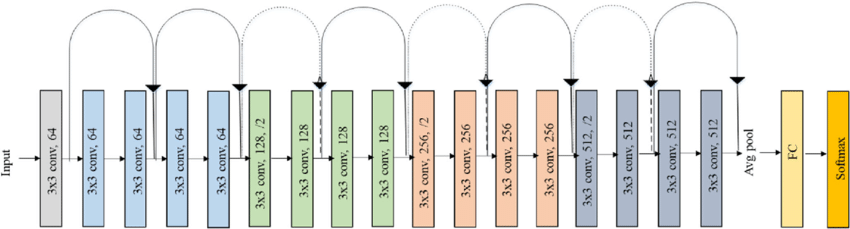

In [ ]:
resnet = torchvision.models.resnet18(pretrained=True) # инициализируем модель
resnet

In [ ]:
def set_parameter_requires_grad(model):
  """
  Функция для заморозки весов модели
  """
  for param in model.parameters():
    param.requires_grad = False
            
set_parameter_requires_grad(resnet)

In [ ]:
# Меняем последний слой модели, чтобы он предсказывал 5 классов, а не 1000
# Когда мы заново определяем слой, у него по умолчанию стоит аттрибут requires_grad = True
# То есть этот полносвязный слой будет обучаться
resnet.fc = nn.Linear(512, 5)

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name)

Запустим функцию обучения модели. Внимание - необходимо заново задать оптимизатор, чтобы он теперь работал с весами resnet

In [ ]:
resnet.to(device)
optimizer = torch.optim.Adam(params = resnet.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=5)

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

Сохраним веса модели:

In [ ]:
weights_fname = '/content/drive/My Drive/data/flower-resnet.pth'
torch.save(resnet.state_dict(), weights_fname)

# Смотрим результат

И посмотрим как модель предсказывает

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, resnet)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, resnet))

# Практическое задание 

В пракическом задание необходимо обучить еще одну сверточную архитектуру для задач классификации цветов. 

В выбранной Вами архитектуре также необходимо разобраться с основными её параметрами и принципами работы.

Посмотрите как использовать [модели в PyTorch](https://pytorch.org/vision/stable/models.html), выберите одну и используя transfer learning до-обучите модель на классификацию цветов. Чтобы это сделать замените ____ в ячейках ниже на работающий код.




In [ ]:
# Выберите модель из списка доступных в PyTorch моделей
# Не забудьте указать, что она модель должна быть предобучена!
model = torchvision.models.googlenet()
model

In [ ]:
set_parameter_requires_grad(_____) # передайте модель в функцию для "заморозки" градиента

In [ ]:
model._____ = _____# Меняем последний слой модели

In [ ]:
# Проверим все ли сработало правильно, выведем веса, которые будут обучаться
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

In [ ]:
model.to(_____) # Отправляем модель на GPU
optimizer = torch.optim.Adam(params = model.parameters()) # алгоритм оптимизации
loss_track, accuracy_track = trainval(resnet, loaders, optimizer, epochs=_____) # запускаем обучение

In [ ]:
plt.plot(accuracy_track['training'], label='training')
plt.plot(accuracy_track['validation'], label='validation')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.grid()
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

def predict_image(img, model):
    # Преобразование to a batch of 1
    xb = img.unsqueeze(0).to(device)
    # Получение прогнозов от модели
    yb = model(xb)
    # Выбираем индекс с наибольшей вероятностью
    _, preds  = torch.max(yb, dim=1)
    # Получение метки класса
    return dataset.classes[preds[0].item()]

for i in range(1,10):
  img, label = val_set[i]
  plt.imshow(img.clip(0,1).permute(1, 2, 0))
  plt.axis('off')
  plt.title('Label: {}, Predicted: {}'.format(dataset.classes[label],predict_image(img, _____)))
  plt.show()
  # print('Label:', dataset.classes[label], ',Predicted:', predict_image(img, ______))

По желанию, можно сохранить веса модели.

In [ ]:
weights_fname = '/content/drive/My Drive/data/***___**.pth'
torch.save(____.state_dict(), weights_fname)

## Вопросы.

Как работает выбранная вами модель сверточной нейронной сети? Какие параметры?

В чем основные отличия между сверточной нейронной сетью и "обычной" полносвязной нейронной сетью?

Что такое transfer learning?

Что такое функция для заморозки весов модели?
